In [1]:
from rat import RAT

/Users/dipalshah/Desktop/bitsdatathon/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
No sentence-transformers model found with name ProsusAI/finbert. Creating a new one with mean pooling.


In [2]:
rat_model = RAT(input_dim=22, embed_dim=32, num_heads=2, num_layers=2, output_dim=2)

/Users/dipalshah/Desktop/bitsdatathon/.venv/lib/python3.12/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [3]:
# Get data (assuming this returns DataFrame with all features)
data = rat_model.get_data("AAPL", start_date="2000-01-01", end_date="2025-03-02")

# Separate stock price/volume from other features
stock_features = data[['Close', 'Volume']].values  # Price and volume
other_features = data.drop(['Close', 'Volume'], axis=1).values.astype(dtype="float32")  # Other features

# Format data for training
input_length = 30  # 30 days of history
output_length = 15  # predict 15 days ahead
X, y = rat_model.format_data_separate(stock_features, other_features, input_length, output_length)

# Train the model
batch_size = 32
epochs = 100
rat_model.train_model(epochs, batch_size, X, y)

/Users/dipalshah/Desktop/bitsdatathon/.venv/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch 1/100, Train Loss: 0.999897, Val Loss: 0.974377
Epoch 5/100, Train Loss: 0.953406, Val Loss: 1.014553
Epoch 10/100, Train Loss: 0.951038, Val Loss: 1.037360
Epoch 15/100, Train Loss: 0.946924, Val Loss: 1.048074
Epoch 20/100, Train Loss: 0.946275, Val Loss: 1.051490
Early stopping at epoch 21


0.9029228488604227

5264301964.619719


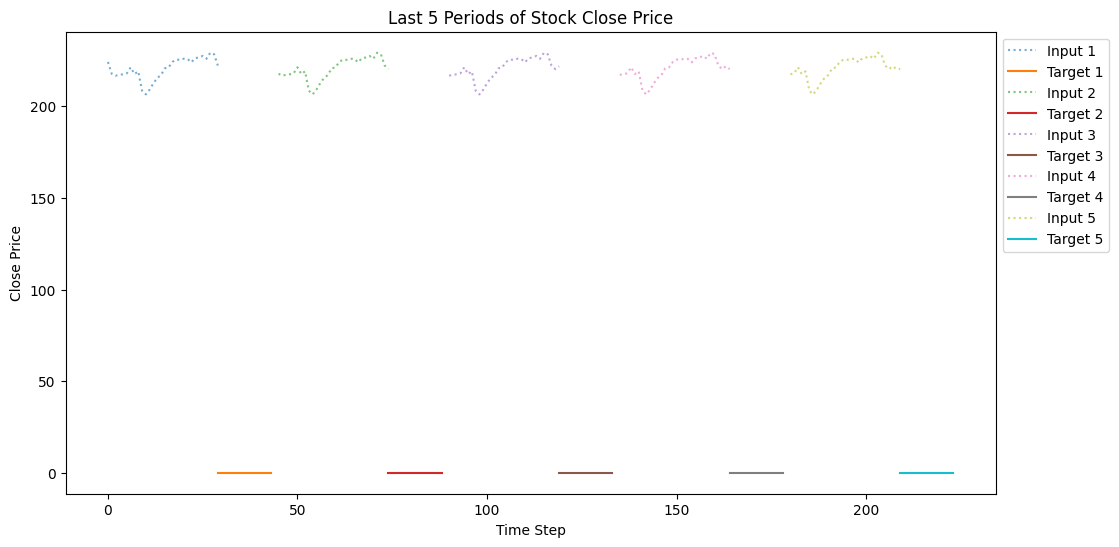

In [5]:
import matplotlib.pyplot as plt
import torch.nn as nn

N = 5

num_samples = X.shape[0]
if N > num_samples:
    N = num_samples  # Ensure N is within range

# Extract the last N periods of input and target for close price
last_X = X[-N:, :, 0].cpu().numpy()  # Shape: (N, input_length)
last_y = rat_model.predict(X)[-N:, :, 0].cpu().numpy()  # Shape: (N, output_length)

criterion = nn.MSELoss()
loss = criterion(rat_model.predict(X), y)
val_loss = loss.item()
avg_val_loss = val_loss / len(y)
print(avg_val_loss)

# Inverse transform close price (since we scaled it)
close_price_scaler = rat_model.stock_scalers[0]
last_X = close_price_scaler.inverse_transform(last_X)

plt.figure(figsize=(12, 6))

for i in range(N):
    input_range = range(i * (last_X.shape[1] + last_y.shape[1]), i * (last_X.shape[1] + last_y.shape[1]) + last_X.shape[1])
    output_range = range(input_range[-1], input_range[-1] + last_y.shape[1])
    
    plt.plot(input_range, last_X[i], label=f"Input {i+1}", linestyle="dotted", alpha=0.6)
    plt.plot(output_range, last_y[i], label=f"Target {i+1}", linestyle="solid")

plt.xlabel("Time Step")
plt.ylabel("Close Price")
plt.title(f"Last {N} Periods of Stock Close Price")
plt.legend(loc="upper left", bbox_to_anchor=(1, 1))
plt.show()